In [8]:
# Installation silencieuse et optimisée des bibliothèques
!pip install --prefer-binary -r requirements.txt

In [9]:
# --- 1. IMPORTATION OUTILS  ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from io import BytesIO
from dotenv import load_dotenv
import boto3

# --- 2. OUTILS MACHINE LEARNING (Scikit-Learn) ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# --- 3. CHARGEMENT DES ACCÈS ---
load_dotenv()

# --- 4. RÉCUPÉRATION DES DONNÉES DEPUIS LE DATA LAKE ---
def load_from_s3(file_name):
    # Connexion avec les id
    s3 = boto3.client(
        's3',
        aws_access_key_id=os.getenv('ACCESS_KEY'),
        aws_secret_access_key=os.getenv('SECRET_KEY'),
        region_name="eu-west-3"
    )
    
    # Lecture du flux de données
    bucket_name = os.getenv('BUCKET_NAME')
    obj = s3.get_object(Bucket=bucket_name, Key=file_name)
    
    # On ramène le fichier nettoyé dans un DataFrame
    data = pd.read_csv(BytesIO(obj['Body'].read()), sep=';')
    return data

# --- 5. INITIALISATION ---
df = load_from_s3("bank_marketing_cleaned_v1.csv")

print(f"✅ Données chargées avec succès depuis S3.")
print(f"📊 Dimensions du dataset : {df.shape}")
df.head()

✅ Données chargées avec succès depuis S3.
📊 Dimensions du dataset : (45211, 18)


,age,metier,statut_matrimonial,niveau_etudes,defaut_credit,solde_bancaire,pret_immo,pret_conso,day,mois,duration,campaign,pdays,previous,resultat_precedent,souscription,segment_contact,age_group
0,58,management,married,tertiary,no,2143,yes,no,5,may,261,1,-1,0,no existant,no,Jamais contacte,Matures(46-63)
1,44,technician,single,secondary,no,29,yes,no,5,may,151,1,-1,0,no existant,no,Jamais contacte,Adultes(31-45)
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,76,1,-1,0,no existant,no,Jamais contacte,Adultes(31-45)
3,47,blue-collar,married,unknown,no,1506,yes,no,5,may,92,1,-1,0,no existant,no,Jamais contacte,Matures(46-63)
4,33,unknown,single,unknown,no,1,no,no,5,may,198,1,-1,0,no existant,no,Jamais contacte,Adultes(31-45)


## Preprocessing 

In [ ]:
#1)  Supprimer les colonnes inutiles :

colonnes_inutiles = ['pdays','age_group']
df_clean = df.drop(columns =colonnes_inutiles)
df_clean.head()


,age,metier,statut_matrimonial,niveau_etudes,defaut_credit,solde_bancaire,pret_immo,pret_conso,day,mois,duration,campaign,previous,resultat_precedent,souscription,segment_contact
0,58,management,married,tertiary,no,2143,yes,no,5,may,261,1,0,no existant,no,Jamais contacte
1,44,technician,single,secondary,no,29,yes,no,5,may,151,1,0,no existant,no,Jamais contacte
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,76,1,0,no existant,no,Jamais contacte
3,47,blue-collar,married,unknown,no,1506,yes,no,5,may,92,1,0,no existant,no,Jamais contacte
4,33,unknown,single,unknown,no,1,no,no,5,may,198,1,0,no existant,no,Jamais contacte


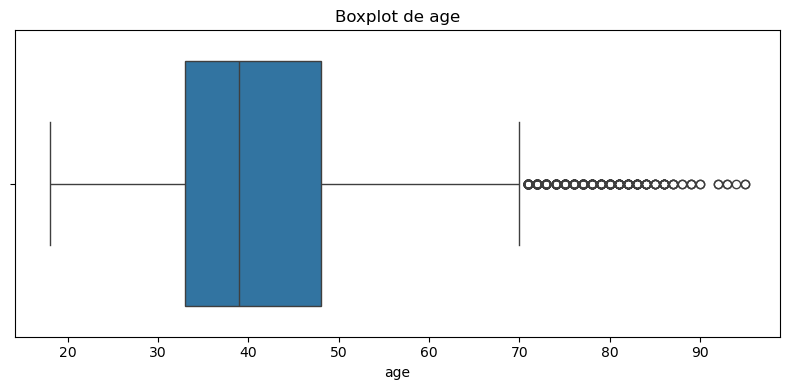

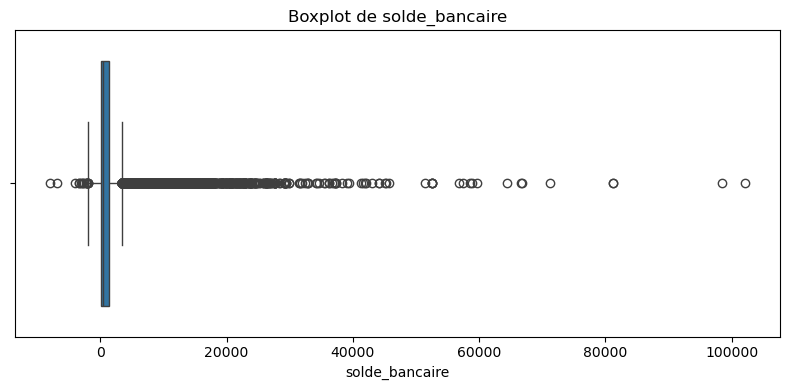

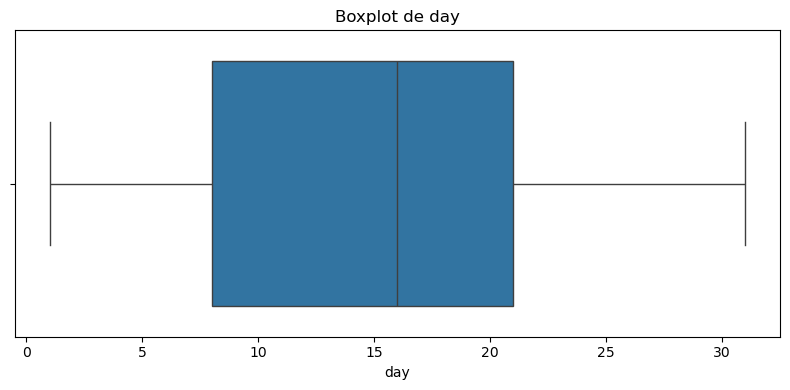

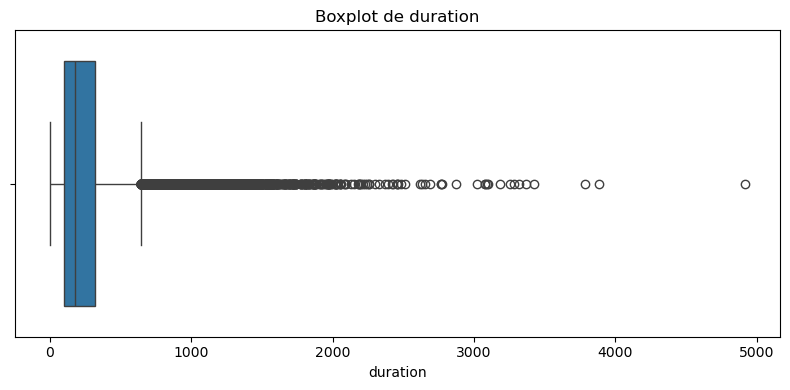

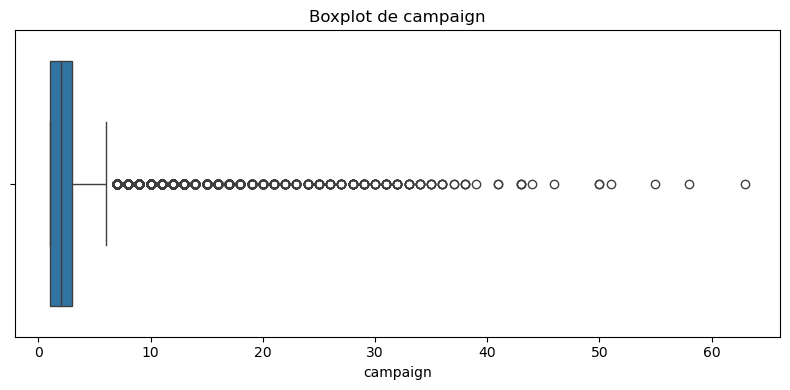

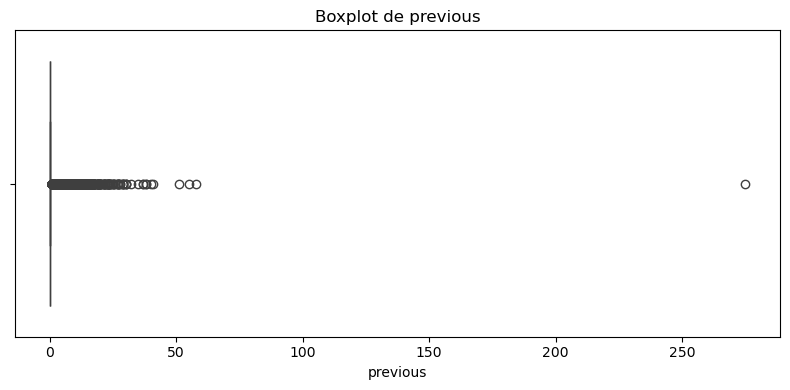

In [13]:
# 2) Déterminer si nous avons des valeurs abérrantes dans toutes les colonnes numeriques :

colonnes_numeriques = df_clean.select_dtypes(include=['int64', 'float64']).columns

# Créer un boxplot pour chaque colonne
for col in colonnes_numeriques:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df_clean[col])
    plt.title(f"Boxplot de {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

In [ ]:
# 3) Détection automatique en pourcentage les valeurs aberrantes sur toutes les colonnes numériques :

numeriques = df_clean.select_dtypes(include=['float64', 'int64']).columns

for col in numeriques:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df_clean[(df_clean[col] < Q1 - 1.5*IQR) | (df_clean[col] > Q3 + 1.5*IQR)]
    print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(df)*100:.1f}%)")

age: 487 outliers (1.1%)
solde_bancaire: 4729 outliers (10.5%)
day: 0 outliers (0.0%)
duration: 3235 outliers (7.2%)
campaign: 3064 outliers (6.8%)
previous: 8257 outliers (18.3%)


In [ ]:
# 4) Pour supprimer les valeurs aberrantes des deux colonnes (campaign,duration et previous) allons utiliser la methode IQR (Interquartile Range) 
# car la distribution n'est pas normal pour utiliser la mothode Z_score

q1 = df_clean['campaign'].quantile(0.25)
q3 = df_clean['campaign'].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
outliers_pages = df_clean[(df_clean['campaign'] < lower) | (df_clean['campaign'] > upper) ]
print(f'Outliers  : {len(outliers_pages)}')

data_clean2 = df_clean[(df_clean['campaign']>= lower) & (df_clean['campaign'] <= upper)]
print(f'Données avant : {len(df_clean)}, après : {len(data_clean2)}')

Outliers  : 3064
Données avant : 45211, après : 42147


In [17]:
q1 = data_clean2['duration'].quantile(0.25)
q3 = data_clean2['duration'].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
outliers_pages = data_clean2[(data_clean2['duration'] < lower) | (data_clean2['duration'] > upper) ]
print(f'Outliers  : {len(outliers_pages)}')

data_clean3 = data_clean2[(data_clean2['duration']>= lower) & (data_clean2['duration'] <= upper)]
print(f'Données avant : {len(data_clean2)}, après : {len(data_clean3)}')

Outliers  : 3015
Données avant : 42147, après : 39132


In [23]:
q1 = data_clean3['previous'].quantile(0.25)
q3 = data_clean3['previous'].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
outliers_pages = data_clean3[(data_clean3['previous'] < lower) | (data_clean3['previous'] > upper) ]
print(f'Outliers  : {len(outliers_pages)}')

data_clean4 = data_clean3[(data_clean3['previous']>= lower) & (data_clean3['previous'] <= upper)]
print(f'Données avant : {len(data_clean3)}, après : {len(data_clean4)}')

Outliers  : 7528
Données avant : 39132, après : 31604


In [ ]:
# 5) Séparer les variables explicatives x et la variable cible y : 
target_variable = 'souscription'
y = data_clean4.loc[: , target_variable]
x = data_clean4.drop(columns= target_variable)
print("x :")
print(x.head())
print()
print("y : ")
print(y.head())


x :
   age        metier statut_matrimonial niveau_etudes defaut_credit  \
0   58    management            married      tertiary            no   
1   44    technician             single     secondary            no   
2   33  entrepreneur            married     secondary            no   
3   47   blue-collar            married       unknown            no   
4   33       unknown             single       unknown            no   

   solde_bancaire pret_immo pret_conso  day mois  duration  campaign  \
0            2143       yes         no    5  may       261         1   
1              29       yes         no    5  may       151         1   
2               2       yes        yes    5  may        76         1   
3            1506       yes         no    5  may        92         1   
4               1        no         no    5  may       198         1   

   previous resultat_precedent  segment_contact  
0         0        no existant  Jamais contacte  
1         0        no existant  Jama

In [28]:
# 6) Détecter les noms des variables numeriques / catégorielles:

num_cols = x.select_dtypes(include=["int64","float64"]).columns
print(f'Found numeric features {list(num_cols)}')


cat_cols = x.select_dtypes(include=["object", "category"]).columns
print(f"Found categorical features {list(cat_cols)}")

Found numeric features ['age', 'solde_bancaire', 'day', 'duration', 'campaign', 'previous']
Found categorical features ['metier', 'statut_matrimonial', 'niveau_etudes', 'defaut_credit', 'pret_immo', 'pret_conso', 'mois', 'resultat_precedent', 'segment_contact']


In [29]:
# 7) Séparer les données pour créer un ensemble de données d'entrainement et un ensemble de données de test (20% de la data):
from sklearn.model_selection import train_test_split


x_train,x_test, y_train,y_test = train_test_split (x,y, test_size = 0.2, random_state=42)

In [ ]:
# 8) Créer un pipeline pour les num_cols ainsi que les cat_cols  :

# A) il n'y aura pas d'imputation car nous n'avons pas de valeurs manquantes.
# B) standardisation pour les num_cols car on va utiliser une régression logistique,  
# C) Encodage des cat_cols :

from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder


numeric_transformer = Pipeline(steps=[ 
    ('scaler', StandardScaler())])
    
categorical_transformer = Pipeline(steps=[
   
    ('encoder', OneHotEncoder(drop='first')) ])

print('....Done.')

....Done.


In [30]:
# 9) création objet préprocesseur avec ColumnTransformer :

from sklearn.compose import ColumnTransformer


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols ),
        ('cat', categorical_transformer, cat_cols)
    ]
)
x_train = preprocessor.fit_transform(x_train)
print(x_train[0:5, :])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 46 stored elements and shape (5, 36)>
  Coords	Values
  (0, 0)	0.7719115705308343
  (0, 1)	0.16084974607666583
  (0, 2)	-1.5348867082033326
  (0, 3)	-0.5994482913940031
  (0, 4)	0.6147798066176954
  (0, 14)	1.0
  (0, 24)	1.0
  (0, 29)	1.0
  (1, 0)	-0.9479682079761209
  (1, 1)	0.5307649320858213
  (1, 2)	0.14866292833601896
  (1, 3)	-0.6492370620411865
  (1, 4)	-0.8810078901262968
  (1, 14)	1.0
  (1, 17)	1.0
  (1, 20)	1.0
  (1, 23)	1.0
  (1, 29)	1.0
  (2, 0)	-0.08802831872264329
  (2, 1)	-0.423448104551432
  (2, 2)	1.471451928474081
  (2, 3)	-0.2936029859898762
  (2, 4)	2.1105675033616875
  (2, 9)	1.0
  (2, 17)	1.0
  (2, 20)	1.0
  (2, 22)	1.0
  (2, 29)	1.0
  (3, 0)	4.020573374377305
  (3, 1)	0.6594592013442513
  (3, 2)	-0.45260479899946376
  (3, 3)	-0.8341667815878678
  (3, 4)	-0.8810078901262968
  (3, 10)	1.0
  (3, 18)	1.0
  (3, 27)	1.0
  (4, 0)	1.249655953449433
  (4, 1)	-0.33646629944962886
  (4, 2)	0.14866292833601896
  (

In [31]:
x_test = preprocessor.transform(x_test)
print(x_test[0:5, : ])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 47 stored elements and shape (5, 36)>
  Coords	Values
  (0, 0)	1.1541070768657131
  (0, 1)	-0.16476615629328134
  (0, 2)	0.2689164738031155
  (0, 3)	-0.8270541000668417
  (0, 4)	-0.8810078901262968
  (0, 9)	1.0
  (0, 17)	1.0
  (0, 20)	1.0
  (0, 33)	1.0
  (1, 0)	0.10306943444479617
  (1, 1)	-0.5579627176456704
  (1, 2)	1.5917054739411776
  (1, 3)	-0.42163125336834795
  (1, 4)	2.1105675033616875
  (1, 12)	1.0
  (1, 17)	1.0
  (1, 21)	1.0
  (1, 24)	1.0
  (1, 29)	1.0
  (2, 0)	-0.7568704548086814
  (2, 1)	-0.268885640467187
  (2, 2)	1.711959019408274
  (2, 3)	1.9113282855282476
  (2, 4)	-0.1331140417543007
  (2, 12)	1.0
  (2, 17)	1.0
  (2, 19)	1.0
  (3, 0)	-0.18357719530636302
  (3, 1)	-0.27405927943235
  (3, 2)	-0.3323512535323672
  (3, 3)	2.7292866604462613
  (3, 4)	-0.8810078901262968
  (3, 6)	1.0
  (3, 17)	1.0
  (3, 19)	1.0
  (3, 23)	1.0
  (3, 32)	1.0
  (4, 0)	-0.4702238250575222
  (4, 1)	-0.4202145801982051
  (4, 2)	1.4714519

## Baseline model (logistic regression)

In [32]:
# 1) Entrainement d'un modele de regression logistique et evaluation de ses performances :

from sklearn.linear_model import LogisticRegression


print('Train model ...')
model = LogisticRegression(max_iter=1000,class_weight='balanced') # class_weight est important pour les données déséquilibrée
model.fit(x_train,y_train)

print( '....Done.')

Train model ...
....Done.


In [33]:
# Prediction sur train : 
y_train_pred = model.predict(x_train)
print('....Done.')
print(y_train_pred[0:5])

....Done.
['no' 'no' 'no' 'yes' 'no']


In [34]:
# Prediction sur test : 
y_test_pred = model.predict(x_test)
print('....Done.')
print(y_test_pred[0:5])

....Done.
['no' 'no' 'yes' 'yes' 'no']


In [ ]:
# Evaluation des performances : 

# Print scores :

from sklearn.metrics import accuracy_score, f1_score


print("Accuracy on training set : ", accuracy_score(y_train, y_train_pred))
print("Accuracy on test set : ", accuracy_score(y_test, y_test_pred))


print(" F1_score on training set : ", f1_score(y_train, y_train_pred, pos_label='yes'))
print(" F1_score on test set : ", f1_score(y_test, y_test_pred, pos_label='yes'))

# Analyse des scores : 
# Accuracy :
# Accuracy est stable, pas de surapprentissage score très proche entre train et test donc le modele généralise bien
# donc le modele prédit bien la classe "non"
# F1_score :
# f1_score est très bas (35-36%), le modele rate la plupart des oui

Accuracy on training set :  0.8088438871969308
Accuracy on test set :  0.8082581869957285
 F1_score on training set :  0.3471565581521005
 F1_score on test set :  0.3634453781512605


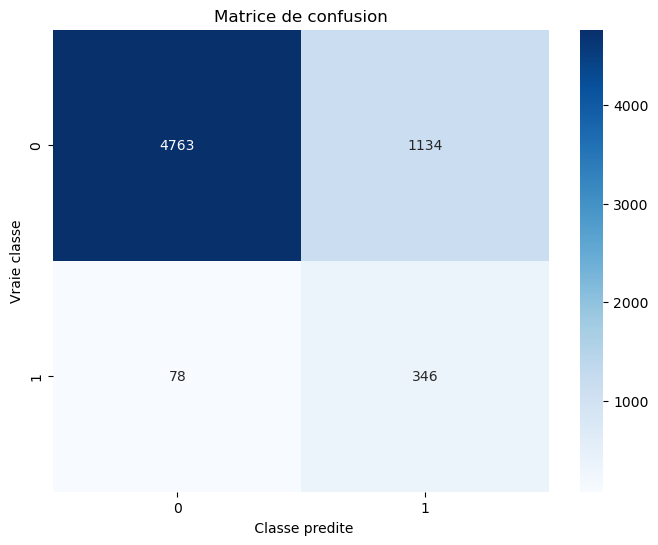

In [ ]:
# Vérifier la matrice de confusion :
from sklearn.metrics import confusion_matrix
cm = confusion_matrix (y_test, y_test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='d',cmap ='Blues')
plt.title('Matrice de confusion')
plt.ylabel('Vraie classe')
plt.xlabel(' Classe predite')
plt.show()

# analyse de la matrice: 
# 82%  le modele trouve la plupart des vrais clients "oui"
# peu de faux négatifs (78) : le modele ne rate que 18% des bons clients
# précision très faible (23%) : les commerciaux contacteront 1134 clients faux positifs donc beacoup d'appel inutiles
# pour conclure avec ce modele pour trouvé un bon client, on doit appeler 3.3 mauvais clients !

Afin d'améliorer notre modele de base nous allons entrainer un autre modele Random forest ce dernier peut gérer ce trade-off

## Random Forest

In [42]:
# Modele Random Forest : 
from sklearn.ensemble import RandomForestClassifier


classifier = RandomForestClassifier( 
    n_estimators=100,
    max_depth=12,
    min_samples_split=50,
    min_samples_leaf=25,
    class_weight = 'balanced',
    random_state=42,
    max_features ='sqrt',
    n_jobs= -1)
classifier.fit(x_train, y_train)
print('...Done.')

...Done.


In [43]:
# Prediction  :
y_pred_train = classifier.predict(x_train)
print('y_pred_train....Done.')
print(y_pred_train[0:5])
y_pred_test = classifier.predict(x_test)
print('y_pred_test....Done.')
print(y_test_pred[0:5])

y_pred_train....Done.
['no' 'no' 'no' 'yes' 'no']
y_pred_test....Done.
['no' 'no' 'yes' 'yes' 'no']


In [ ]:
# Evaluation des performances : 

# Print scores :

print("Accuracy on training set : ", accuracy_score(y_train, y_pred_train))
print("Accuracy on test set : ", accuracy_score(y_test, y_pred_test))


print(" F1_score on training set : ", f1_score(y_train, y_pred_train, pos_label='yes'))
print(" F1_score on test set : ", f1_score(y_test, y_pred_test, pos_label='yes'))

# Analyse des scores :
# pas de surapprentissage : train f1 = 40.3% et test f1 = 38.4% => écart minim donc le modele généralise bien
# Accuracy stable, différence négligable

Accuracy on training set :  0.8349088320215164
Accuracy on test set :  0.8242366714127511
 F1_score on training set :  0.4026903262736119
 F1_score on test set :  0.3844875346260388
